In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare 

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

using functions created to acquire and wrangle the data

In [2]:
df = acquire.get_zillow_data()

df = prepare.remove_outliers(df)
df = prepare.handle_nulls(df)
df = prepare.rename_columns(df)
df = prepare.prepare_locs(df)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47936 entries, 0 to 52440
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   parcelid          47936 non-null  int64         
 1   bathrooms         47936 non-null  float64       
 2   bedrooms          47936 non-null  float64       
 3   square_feet       47936 non-null  int64         
 4   fips              47936 non-null  int64         
 5   garages           47936 non-null  int64         
 6   garage_size       47936 non-null  int64         
 7   lot_size          47936 non-null  int64         
 8   has_pool          47936 non-null  bool          
 9   year_built        47936 non-null  int64         
 10  log_error         47936 non-null  float64       
 11  transaction_date  47936 non-null  datetime64[ns]
 12  county            47936 non-null  object        
 13  latitude          47936 non-null  float64       
 14  longitude         4793

this looks good for now... let's think about some things to explore-

-curious to see if transaction date and log error have any relation, like does the time of year of transation increase/dec likelihood of error?

-let's look for like-things... how closely linked are bedroom and bathroom, could they be combined to one feature?

-what does the correlatoin to log error chart look like?

-what can we bin? keep this in mind through exploration.

-look at square feet and year together. do homes get bigger over time?

-what if we tried K means on lat, long and square feet?

-let's start here and keep adding ideas here when they come up

-look at pool

In [8]:
xsmall_df = df.copy().where(train.square_feet < 1184)
xsmall_df = xsmall_df.dropna()

In [9]:
train, test = train_test_split(xsmall_df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting


**Number of Train Records:** 2,699

**Number of Validate Records:** 1,157

**Number of Test Records:** 965

In [10]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [11]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train[['bathrooms', 'bedrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

train[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']] = scaler.transform(train[['bathrooms', 'bedrooms', 'square_feet']])

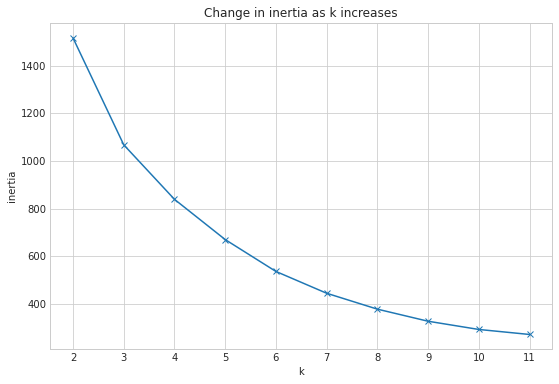

In [12]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [13]:
X = train[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

kmeans.predict(X)

train['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,scalbathrooms,scalbedrooms,scalsquare_feet
0,0.025401,0.504011,0.863812
1,0.007843,0.234118,0.239095
2,0.001890,0.241497,0.507639
3,0.336142,0.531835,0.879879
4,0.327642,0.301220,0.714730
5,0.006720,0.237231,0.821179
6,0.006705,0.504310,0.620970


In [14]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(validate[['bathrooms', 'bedrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

validate[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']] = scaler.transform(validate[['bathrooms', 'bedrooms', 'square_feet']])

In [15]:
X = validate[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

kmeans.predict(X)

validate['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,scalbathrooms,scalbedrooms,scalsquare_feet
0,0.486842,0.285088,0.610217
1,0.506024,0.500000,0.881816
2,0.002463,0.245074,0.492740
3,0.050279,0.511173,0.849676
4,0.002857,0.232857,0.233653
5,0.020134,0.243289,0.805042
6,0.003448,0.503448,0.609924


In [16]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(test[['bathrooms', 'bedrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

test[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']] = scaler.transform(test[['bathrooms', 'bedrooms', 'square_feet']])

In [17]:
X = test[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

kmeans.predict(X)

test['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,scalbathrooms,scalbedrooms,scalsquare_feet
0,0.507853,0.705061,0.863815
1,0.005137,0.324201,0.522553
2,0.022727,0.328283,0.836759
3,0.012411,0.666667,0.621519
4,0.006667,0.297778,0.231907
5,0.500000,0.339869,0.731891
6,0.037338,0.670996,0.859896


In [23]:
xsmall_train = train.copy().where(train.square_feet < 1184)
xsmall_train = xsmall_train.dropna()

xsmall_validate = validate.copy().where(validate.square_feet < 1184)
xsmall_validate = xsmall_validate.dropna()

xsmall_test = test.copy().where(test.square_feet < 1184)
xsmall_test = xsmall_test.dropna()

small = train.copy().where((train.square_feet >= 1184) & (train.square_feet < 1423))
small = small.dropna()

med = train.copy().where((train.square_feet >= 1423) & (train.square_feet < 1988))
med = med.dropna()

large = train.copy().where((train.square_feet >= 1988))
large = large.dropna()

In [17]:
xsmall_train

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,has_pool,year_built,log_error,transaction_date,county,latitude,longitude,scalbathrooms,scalbedrooms,scalsquare_feet,cluster
2396,12675421.0,1.0,3.0,1112.0,6037.0,0.0,0.0,5500.0,True,1955.0,0.106983,2017-01-18,los_angeles,33.854643,-118.368062,0.000,0.50,0.095258,0.0
18215,12069152.0,1.0,2.0,1132.0,6037.0,0.0,0.0,7376.0,False,1922.0,0.343834,2017-04-17,los_angeles,34.148401,-118.241811,0.000,0.25,0.099381,3.0
7085,14037285.0,1.5,3.0,1032.0,6059.0,2.0,441.0,6000.0,False,1962.0,-0.013230,2017-02-17,orange,33.738875,-118.016219,0.125,0.50,0.078763,0.0
25122,12724899.0,1.0,3.0,1149.0,6037.0,0.0,0.0,5592.0,False,1955.0,-0.002918,2017-05-18,los_angeles,33.918446,-118.087261,0.000,0.50,0.102887,0.0
15196,12230959.0,1.0,3.0,1060.0,6037.0,0.0,0.0,6249.0,False,1948.0,0.121127,2017-03-31,los_angeles,33.932195,-118.226608,0.000,0.50,0.084536,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34988,10974377.0,1.0,3.0,822.0,6037.0,0.0,0.0,5210.0,False,1952.0,-0.086975,2017-06-28,los_angeles,34.299496,-118.430293,0.000,0.50,0.035464,0.0
2513,10967999.0,1.0,3.0,1134.0,6037.0,0.0,0.0,7149.0,False,1948.0,-0.004223,2017-01-18,los_angeles,34.297532,-118.444864,0.000,0.50,0.099794,0.0
14253,10888745.0,2.0,3.0,1070.0,6037.0,0.0,0.0,10124.0,False,1941.0,-0.013617,2017-03-29,los_angeles,34.184044,-118.392643,0.250,0.50,0.086598,5.0
21777,12630399.0,1.0,1.0,1056.0,6037.0,0.0,0.0,3241.0,False,1923.0,-0.077851,2017-05-03,los_angeles,33.786779,-118.262878,0.000,0.00,0.083711,3.0


In [18]:
X_train = train.drop(columns=['parcelid', 'bedrooms', 'bathrooms', 'fips', 'garages', 'garage_size', 'lot_size', 'has_pool', 'transaction_date', 'log_error', 'scalbathrooms', 'scalbedrooms', 'scalsquare_feet', 'latitude', 'longitude', 'county'])
# creates dataframe that drops all column except the selected features for modeling
y_train = train[['log_error']]
# creates dataframe of target variable (y) only

X_validate = validate.drop(columns=['parcelid', 'bedrooms', 'bathrooms', 'fips', 'garages', 'garage_size', 'lot_size', 'has_pool', 'transaction_date', 'log_error', 'scalbathrooms', 'scalbedrooms', 'scalsquare_feet', 'latitude', 'longitude', 'county'])
y_validate = validate[['log_error']]
# repeat above for validate set

X_test = test.drop(columns=['parcelid', 'bedrooms', 'bathrooms', 'fips', 'garages', 'garage_size', 'lot_size', 'has_pool', 'transaction_date', 'log_error', 'scalbathrooms', 'scalbedrooms', 'scalsquare_feet', 'latitude', 'longitude', 'county'])
y_test = test[['log_error']]

In [19]:
X_train

,square_feet,year_built,cluster
20028,932.0,1949.0,4
776,912.0,1960.0,6
45551,1116.0,1955.0,5
12710,816.0,1952.0,1
20665,1052.0,1958.0,3
...,...,...,...
36972,779.0,1982.0,1
28020,1118.0,1951.0,3
917,1075.0,1937.0,5
41860,1055.0,1950.0,0


In [20]:
scaler = sklearn.preprocessing.MinMaxScaler()
# employs the min max scaler
scaler.fit(X_train[['cluster', 'square_feet', 'year_built']])
# inserts the 4 selected features into the scaler

X_train[['scaledcluster', 'scaledsize', 'scaledyear']] = data=scaler.transform(X_train[['cluster', 'square_feet', 'year_built']])
X_validate[['scaledcluster', 'scaledsize', 'scaledyear']] = data=scaler.transform(X_validate[['cluster', 'square_feet', 'year_built']])
X_test[['scaledcluster', 'scaledsize', 'scaledyear']] = data=scaler.transform(X_test[['cluster', 'square_feet', 'year_built']]) 

In [39]:
X_train

,square_feet,year_built,cluster,scaledcluster,scaledsize,scaledyear
2396,1112.0,1955.0,0.0,0.000000,0.866792,0.441176
18215,1132.0,1922.0,3.0,0.500000,0.904315,0.117647
7085,1032.0,1962.0,0.0,0.000000,0.716698,0.509804
25122,1149.0,1955.0,0.0,0.000000,0.936210,0.441176
15196,1060.0,1948.0,0.0,0.000000,0.769231,0.372549
...,...,...,...,...,...,...
34988,822.0,1952.0,0.0,0.000000,0.322702,0.411765
2513,1134.0,1948.0,0.0,0.000000,0.908068,0.372549
14253,1070.0,1941.0,5.0,0.833333,0.787992,0.303922
21777,1056.0,1923.0,3.0,0.500000,0.761726,0.127451


In [21]:
X_train = X_train.drop(columns = ['cluster', 'square_feet', 'year_built'])
X_validate = X_validate.drop(columns = ['cluster', 'square_feet', 'year_built'])
X_test = X_test.drop(columns = ['cluster', 'square_feet','year_built'])

In [22]:
lm = LinearRegression(normalize=True)
# create the model

lm.fit(X_train, y_train.log_error)
# fit the model to scaled training data

y_train['value_predict_lm'] = lm.predict(X_train)
# computes model predictions

In [25]:
y_train['value_predict_lm'].mean() < y_train['log_error'].mean()

False

In [23]:
y_train['value_predict_lm'].mean()

0.009699969156530068

In [24]:
y_train['log_error'].mean()

0.009699969156530045

In [41]:
# small = train.copy().where((train.square_feet >= 1184) & (train.square_feet < 1393))
# small = small.dropna()

In [44]:
# xlarge = train.copy().where(train.square_feet >= 4000)
# xlarge = large.dropna()

In [55]:
# xlarge = train.copy().where(train.square_feet >= 2000)
# xlarge = large.dropna()